In [4]:
### this is a revised notebook to cluster attackers based on distance (closest to each other in terms of performance)
### spatial distance is used to perform distance based clustring instead of K-means and DBSCAN used in feature_selection.ipynb |

### Libraries

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

### Data

In [3]:
df_all = pd.read_csv('all_players_with_valuations.csv')

### Merging data

In [4]:
df_all.head()

id_player        player_name  nationality field_position  id_team  assists  \
0  250016833         harry kane      England        Forward    50037      1.0   
1  250105927    viktor gyokeres       Sweden        Forward    50149      0.0   
2  250121533    vinicius junior       Brazil        Forward    50051      0.0   
3  250121294  tijjani reijnders  Netherlands     Midfielder    50058      0.0   
4  250160436  maghnes akliouche       France     Midfielder    50023      1.0   

   corners_taken  offsides  dribbles  total_attempts  ...  other  \
0            0.0       3.0      10.0            20.0  ...    0.0   
1            0.0       3.0       6.0            15.0  ...    0.0   
2            7.0       0.0      34.0            17.0  ...    0.0   
3            0.0       1.0       7.0             8.0  ...    0.0   
4            9.0       2.0      10.0            10.0  ...    0.0   

   penalties_scored  distance_covered(km/h)  top_speed  minutes_played  \
0               3.0                   43.71      30.35           360.0   
1               2.0                   41.94      34.55           360.0   
2               1.0                   38.39      35.47           360.0   
3               0.0                   46.61      32.26           360.0   
4               0.0                   44.67      33.39           360.0   

   matches_appareance          Position   Age  Market Value      Club Name  
0                 4.0    Centre-Forward  31.0      €150.00m  Bayern Munich  
1                 4.0    Centre-Forward  26.0       €75.00m    Sporting CP  
2                 4.0       Left Winger  24.0      €200.00m    Real Madrid  
3                 4.0  Central Midfield  26.0       €50.00m       AC Milan  
4                 4.0      Right Winger  22.0       €40.00m      AS Monaco  

[5 rows x 51 columns]

In [6]:
# Filtering the data by field_positoin for Forward players only
attackers_df = df_all[df_all['field_position'] == 'Forward']
attackers_df

id_player          player_name nationality field_position  id_team  \
0    250016833           harry kane     England        Forward    50037   
1    250105927      viktor gyokeres      Sweden        Forward    50149   
2    250121533      vinicius junior      Brazil        Forward    50051   
18   250134304   gabriel martinelli      Brazil        Forward    52280   
92   250130406       johan bakayoko     Belgium        Forward    50062   
..         ...                  ...         ...            ...      ...   
631  250138623          indrit tuci     Albania        Forward    50033   
638  250180810     jarzinho malanga     Germany        Forward    50107   
642  250137395      samuel mbangula     Belgium        Forward    50139   
647  250172594         petar ratkov      Serbia        Forward    50030   
653  250138999  andreas schjelderup      Norway        Forward    50147   

     assists  corners_taken  offsides  dribbles  total_attempts  ...  other  \
0        1.0            0.0       3.0      10.0            20.0  ...    0.0   
1        0.0            0.0       3.0       6.0            15.0  ...    0.0   
2        0.0            7.0       0.0      34.0            17.0  ...    0.0   
18       1.0            4.0       0.0       8.0             8.0  ...    0.0   
92       1.0            0.0       1.0      14.0            13.0  ...    0.0   
..       ...            ...       ...       ...             ...  ...    ...   
631      0.0            0.0       0.0       0.0             0.0  ...    0.0   
638      0.0            0.0       0.0       0.0             1.0  ...    0.0   
642      0.0            0.0       0.0       0.0             0.0  ...    0.0   
647      0.0            0.0       0.0       0.0             0.0  ...    0.0   
653      0.0            0.0       0.0       0.0             0.0  ...    0.0   

     penalties_scored  distance_covered(km/h)  top_speed  minutes_played  \
0                 3.0                   43.71      30.35           360.0   
1                 2.0                   41.94      34.55           360.0   
2                 1.0                   38.39      35.47           360.0   
18                0.0                   43.12      34.39           360.0   
92                0.0                   42.93      34.52           352.0   
..                ...                     ...        ...             ...   
631               0.0                    1.88      27.54            12.0   
638               0.0                    1.83      27.91            10.0   
642               0.0                    1.94      29.33             9.0   
647               0.0                    1.23      25.67             7.0   
653               0.0                    0.89      27.47             3.0   

     matches_appareance        Position   Age  Market Value          Club Name  
0                   4.0  Centre-Forward  31.0      €150.00m      Bayern Munich  
1                   4.0  Centre-Forward  26.0       €75.00m        Sporting CP  
2                   4.0     Left Winger  24.0      €200.00m        Real Madrid  
18                  4.0     Left Winger  23.0       €85.00m         Arsenal FC  
92                  4.0    Right Winger  21.0       €45.00m      PSV Eindhoven  
..                  ...             ...   ...           ...                ...  
631                 1.0  Centre-Forward  24.0        €1.00m   AC Sparta Prague  
638                 1.0     Left Winger  18.0        €1.40m      VfB Stuttgart  
642                 1.0     Left Winger  21.0        €8.00m        Juventus FC  
647                 1.0  Centre-Forward  21.0        €6.00m  Red Bull Salzburg  
653                 1.0     Left Winger  20.0       €10.00m         SL Benfica  

[146 rows x 51 columns]

### Feature selection and preprocessing

In [31]:
# Feature selection
attackers_features = ['goals', 'top_speed', 'assists', 'dribbles', 'attempts_on_target', 'total_attempts', 'right_foot',
                     'left_foot', 'head', 'inside_area', 'outside_area']

# DataFrame with attackers features
X = attackers_df[attackers_features].copy()

X

goals  top_speed  assists  dribbles  attempts_on_target  total_attempts  \
0      5.0      30.35      1.0      10.0                12.0            20.0   
1      5.0      34.55      0.0       6.0                 8.0            15.0   
2      4.0      35.47      0.0      34.0                10.0            17.0   
18     0.0      34.39      1.0       8.0                 3.0             8.0   
92     1.0      34.52      1.0      14.0                 5.0            13.0   
..     ...        ...      ...       ...                 ...             ...   
631    0.0      27.54      0.0       0.0                 0.0             0.0   
638    0.0      27.91      0.0       0.0                 0.0             1.0   
642    0.0      29.33      0.0       0.0                 0.0             0.0   
647    0.0      25.67      0.0       0.0                 0.0             0.0   
653    0.0      27.47      0.0       0.0                 0.0             0.0   

     right_foot  left_foot  head  inside_area  outside_area  
0           5.0        0.0   0.0          5.0           0.0  
1           5.0        0.0   0.0          5.0           0.0  
2           2.0        2.0   0.0          3.0           1.0  
18          0.0        0.0   0.0          0.0           0.0  
92          0.0        1.0   0.0          0.0           1.0  
..          ...        ...   ...          ...           ...  
631         0.0        0.0   0.0          0.0           0.0  
638         0.0        0.0   0.0          0.0           0.0  
642         0.0        0.0   0.0          0.0           0.0  
647         0.0        0.0   0.0          0.0           0.0  
653         0.0        0.0   0.0          0.0           0.0  

[146 rows x 11 columns]

In [35]:
# Splitting the data into training and testing data
X_train, X_test, df_train, df_test = train_test_split(X, attackers_df, test_size=0.1, random_state=42)

In [36]:
X_train

goals  top_speed  assists  dribbles  attempts_on_target  total_attempts  \
175    1.0      30.59      0.0       2.0                 5.0            13.0   
320    0.0      33.15      0.0       1.0                 4.0             6.0   
618    0.0      30.18      0.0       0.0                 0.0             1.0   
163    2.0      34.29      1.0      14.0                 3.0             8.0   
303    1.0      33.37      1.0      11.0                 1.0             4.0   
..     ...        ...      ...       ...                 ...             ...   
346    0.0      33.78      0.0      11.0                 1.0             5.0   
484    0.0      31.40      0.0       1.0                 0.0             0.0   
124    0.0      33.68      3.0       5.0                 2.0             9.0   
445    0.0      33.70      0.0       1.0                 2.0             3.0   
476    0.0      33.85      0.0       3.0                 1.0             6.0   

     right_foot  left_foot  head  inside_area  outside_area  
175         0.0        0.0   1.0          1.0           0.0  
320         0.0        0.0   0.0          0.0           0.0  
618         0.0        0.0   0.0          0.0           0.0  
163         1.0        1.0   0.0          2.0           0.0  
303         0.0        1.0   0.0          1.0           0.0  
..          ...        ...   ...          ...           ...  
346         0.0        0.0   0.0          0.0           0.0  
484         0.0        0.0   0.0          0.0           0.0  
124         0.0        0.0   0.0          0.0           0.0  
445         0.0        0.0   0.0          0.0           0.0  
476         0.0        0.0   0.0          0.0           0.0  

[131 rows x 11 columns]

In [51]:
# Reset the index of df_train
df_train.reset_index(drop=True, inplace=True)

In [52]:
# Data scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [53]:
X_train_scaled

array([[ 0.24280283, -1.03808788, -0.52459522, ...,  5.63471383,
         0.33774635, -0.27656005],
       [-0.59422797,  0.37582306, -0.52459522, ..., -0.1774713 ,
        -0.56520818, -0.27656005],
       [-0.59422797, -1.26453455, -0.52459522, ..., -0.1774713 ,
        -0.56520818, -0.27656005],
       ...,
       [-0.59422797,  0.66854681,  3.22387608, ..., -0.1774713 ,
        -0.56520818, -0.27656005],
       [-0.59422797,  0.67959299, -0.52459522, ..., -0.1774713 ,
        -0.56520818, -0.27656005],
       [-0.59422797,  0.76243933, -0.52459522, ..., -0.1774713 ,
        -0.56520818, -0.27656005]], shape=(131, 11))

### Similarity calculations (Distance based)

In [59]:
player_name = "jonathan david" # to test

In [60]:
# Find similar players in the training set
try:
    player_index = df_train[df_train['player_name'] == player_name].index[0] #look within train set

except IndexError:
    print(f"Player '{player_name}' not found in the training dataset.")
    similar_players_df = None  # Set similar_players_df to None if the player is not found
    
# Using pairwise_distance calculation
else:
    distances = pairwise_distances(X_train_scaled, X_train_scaled[player_index].reshape(1, -1), metric='euclidean')
    distances = distances.flatten()
    
# Get indices of the n smallest distances (excluding the player itself)
    similar_player_indices = np.argsort(distances)[1:10 + 1]
    
# Create a DataFrame of similar players and their similarity scores
    similar_players_df = pd.DataFrame({
        'player_name': df_train.loc[similar_player_indices, 'player_name'].values, #get names from train
        'similarity_score': 1 / (1 + distances[similar_player_indices])  # Convert distance to similarity
    })

if similar_players_df is not None:
    print(f"Top 10 players similar to {player_name} (found in the training set):")
    print(similar_players_df)

Top 10 players similar to jonathan david (found in the training set):
          player_name  similarity_score
0    kerem akturkoglu          0.313645
1           luis diaz          0.267571
2  robert lewandowski          0.267176
3     serhou guirassy          0.235200
4       abdallah sima          0.226534
5       donyell malen          0.213830
6     viktor gyokeres          0.211145
7      bruno petkovic          0.196355
8     victor olatunji          0.194110
9        daizen maeda          0.189832


### Clustering

In [61]:
# Find Best Parameters for K-Means using GridSearchCV
param_grid = {
    'n_clusters': range(2, 21),  # Test different numbers of clusters
    'init': ['k-means++', 'random'],
    'max_iter': [300, 500, 1000],
    'n_init': [10, 'auto'],
    'algorithm': ['lloyd', 'elkan']
}

# Istantiate the model
kmeans = KMeans()

# GridSearch to find best params
def silhouette_score_wrapper(estimator, X):
    """Wrapper function to calculate silhouette score within GridSearchCV."""
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

grid_search = GridSearchCV(kmeans, param_grid, scoring=silhouette_score_wrapper, cv=3, verbose=1)
grid_search.fit(X_train_scaled)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Fitting 3 folds for each of 456 candidates, totalling 1368 fits
Best parameters: {'algorithm': 'elkan', 'init': 'k-means++', 'max_iter': 500, 'n_clusters': 2, 'n_init': 'auto'}
Best score: 0.5628336967788065


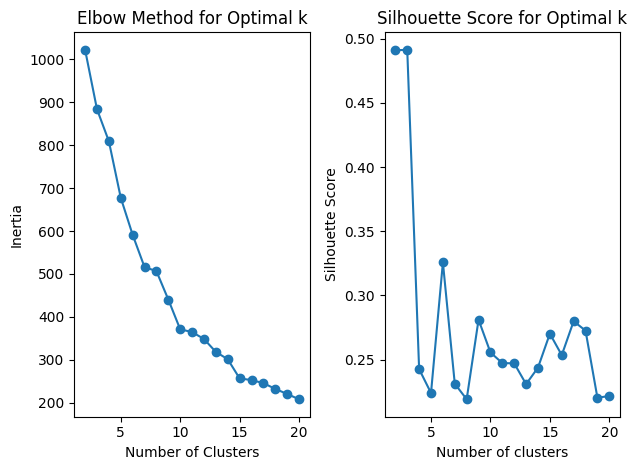

In [63]:
# optimal number of clusters using the elbow method and silhouette score
inertia = []
silhouette_scores_km = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores_km.append(silhouette_score(X_train_scaled, kmeans.labels_))

# Plot the elbow graph
# plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 21), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')


# Plot Silhouette score
plt.subplot(1, 2, 2)
plt.plot(range(2, 21), silhouette_scores_km, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()


In [64]:
# Train K-Means with Best Parameters
kmeans_best = KMeans(**best_params, random_state=42)  # Use the best parameters found by GridSearchCV
kmeans_best.fit(X_train_scaled)

# Get cluster labels for both train and test sets
cluster_labels_train = kmeans_best.labels_
cluster_labels_test = kmeans_best.predict(X_test_scaled)